In [2]:
from setup_libs import *
from plot_clas import *

# [Градиентный бустинг](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)

Давайте теперь попробуем обобщить идею бустинга для произвольных функций потерь.

## Постановка задачи

#### Дано:
* $(X, y)_{N}$ - тренировочная выборка длины $N$
* $Q(a, X, y) = \sum_{i=1}^{N}\mathcal{L}(a, x_i, y_i)$ - функционал минимизации и функция потерь

#### Найти:
* $a = argmin_{f \in \mathcal{A}}Q(f, X, y)$

где $\mathcal{A}$ - семейство алгоритмов, в которых ищем решение

## Решение

На алгоритм $a$ можно смотреть:
* **в теории** как на вектор в бесконечномерном пространстве
* **на практике** как на вектор значений $a(X)$ в конечномерном пространстве размерности длины выборки $N$

Значит можно брать производную по вектору
$$\nabla_{a}Q = \Big[\frac{\partial Q(a, X, y)}{\partial a(x_i)}\Big]_{i=1}^N = \Big[\frac{\partial \sum_{i=1}^{N}\mathcal{L}(a, x_i, y_i)}{\partial a(x_i)}\Big]_{i=1}^N = \Big[\frac{\partial \mathcal{L}(a,x_i, y_i)}{\partial a(x_i)}\Big]_{i=1}^N$$

Тогда найдем необходимый вектор с помощью **градиентного спуска**

$$a^{(t)} = a^{(t - 1)} + \eta\nabla_{a^{(t - 1)}}Q $$


### Бустинг
#### Идея 1.
Будем искать решение в виде **взвешенной** комбинации алгоритмов:
 $$a(x) = \sum_{t = 1}^{T} \alpha_t b_t(x)$$

* $b_1, \ldots, b_T\in \mathcal{B}$ - пространство базовых алгоритмов, из которого будем брать алгоритмы (например деревья решений)
* $\alpha_1, \ldots, \alpha_T\in \mathbb{R}$ - коэффициенты

Неполный алгоритм обозначим как 

$$f_{T}(x) = \sum_{t = 1}^{T} \alpha_t b_t(x)$$

Отсюда очевидно

$$f_T(x) = f_{T-1}(x) + \alpha_T b_T(x)$$

Это в точности **формула градиентного спуска**, где в качестве коэффициента шага спуска $\mu$ используется $\alpha_T$, а в качестве приращения $\nabla_{a^{(t-1)}}Q$ используется некий базовый алгоритм $b_T$. А $a^{(T)}$ обозначено как $f_T$. 



#### Идея 2.
Давайте обучим алгоритм $b_T$ так, чтобы он аппроксимировал функцию градиента $g^{T} = -\nabla_{f_T}Q$. 

Будем решать задачу **регрессии** с данными $(X, g^T(X))$ и алгоритмом $b_T$. (Для простоты обозначим $g^T = g^T(X)$). 

В качестве функционала можно использовать как $MSE$, так и $MAE$ 

$$b_T = argmin_{b\in \mathcal{B}}\sum_{i=1}^{N}(b(x_i) - g_i^{T})^2$$


#### Идея 3.
После того как нашли $b_T$ найдем $\alpha$
$$\alpha_t = \arg\min_\alpha \sum_{i=1}^n L(f_{t-1}(x_i) + \alpha b_t(x_i), y_i)$$

Решаем аналогично по производной:
$$\frac{\partial Q_t(f_t, X, y)}{\partial\alpha_t} = \frac{\partial\sum_{i=1}^N \mathcal{L}(f_t(x_i), y_i)}{\partial\alpha_t} = \sum_{i=1}^N\frac{\partial \mathcal{L}(f_t(x_i), y_i)}{\partial f_t(x_i)} \frac{\partial (f_{t-1}(x_i) + \alpha_t b_t(x_i))}{\partial\alpha_t} = 
\sum_{i=1}^N\frac{\partial \mathcal{L}(f_t(x_i), y_i)}{\partial f_t(x_i)} b_t(x_i) = 0$$


### Итог:

Мы итеративно собираем алгоритм $f_T(x) = \sum_{t=1}^{T}\alpha_t b_t(x)$ из алгоритмов $b_t$ в ходе градиентного спуска. 
Можно самим контролировать количество шагов спуска, можно и останавливать по достижению определенной минимальной разницы между алгоритмами. 

Каждый алгоритм $b_t$ находится через регрессию по антиградиентам.

### Aлгоритм
- Инициализация композиции оптимальным константным значением 

$$f_0 = \arg\min_{c \in \mathbb{R}} \sum_{i=1}^n \mathcal{L}(c, y_i)$$ 

- Для всех $t = 1, \dots, T$:
    * Вычислить остатки предыдущей композиции: 
    
    $$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$$
    
    * Настроить базовую регрессию $b_t(x)$ на полученные остатки, т.е. обучить его по выборке $\{(x_i, g_{i}^{t}), i = 1, \dots, n\}$.
    * Вычислить коэффициент $\alpha_t$ перед базовым алгоритмом $b_t(x)$ как решение следующей задачи оптимизации:
    $$\alpha_t = \arg\min_\alpha \sum_{i=1}^N \mathcal{L}(f_{t-1}(x_i) + \alpha b_t(x_i), y_i)$$
    
    Решение находится из уравнения
    $$\frac{\partial Q_t(f_t, X, y)}{\partial \alpha_t} =  \sum_{i=1}^N\frac{\partial \mathcal{L}(f_t(x_i), y_i)}{\partial f_t(x_i)} b_t(x_i) = 0$$
    
    * Добавить полученное слагаемое в композицию: $f_t(x) = f_{t-1}(x) + \alpha_t b_t(x)$.

В результате получаем алгоритм $a(x) = f_T(x) = \sum_{t=1}^T \alpha_tb_t(x)$

Чтобы получить предсказание достаточно получить результат: $y_{pred} = a(x_{pred})$

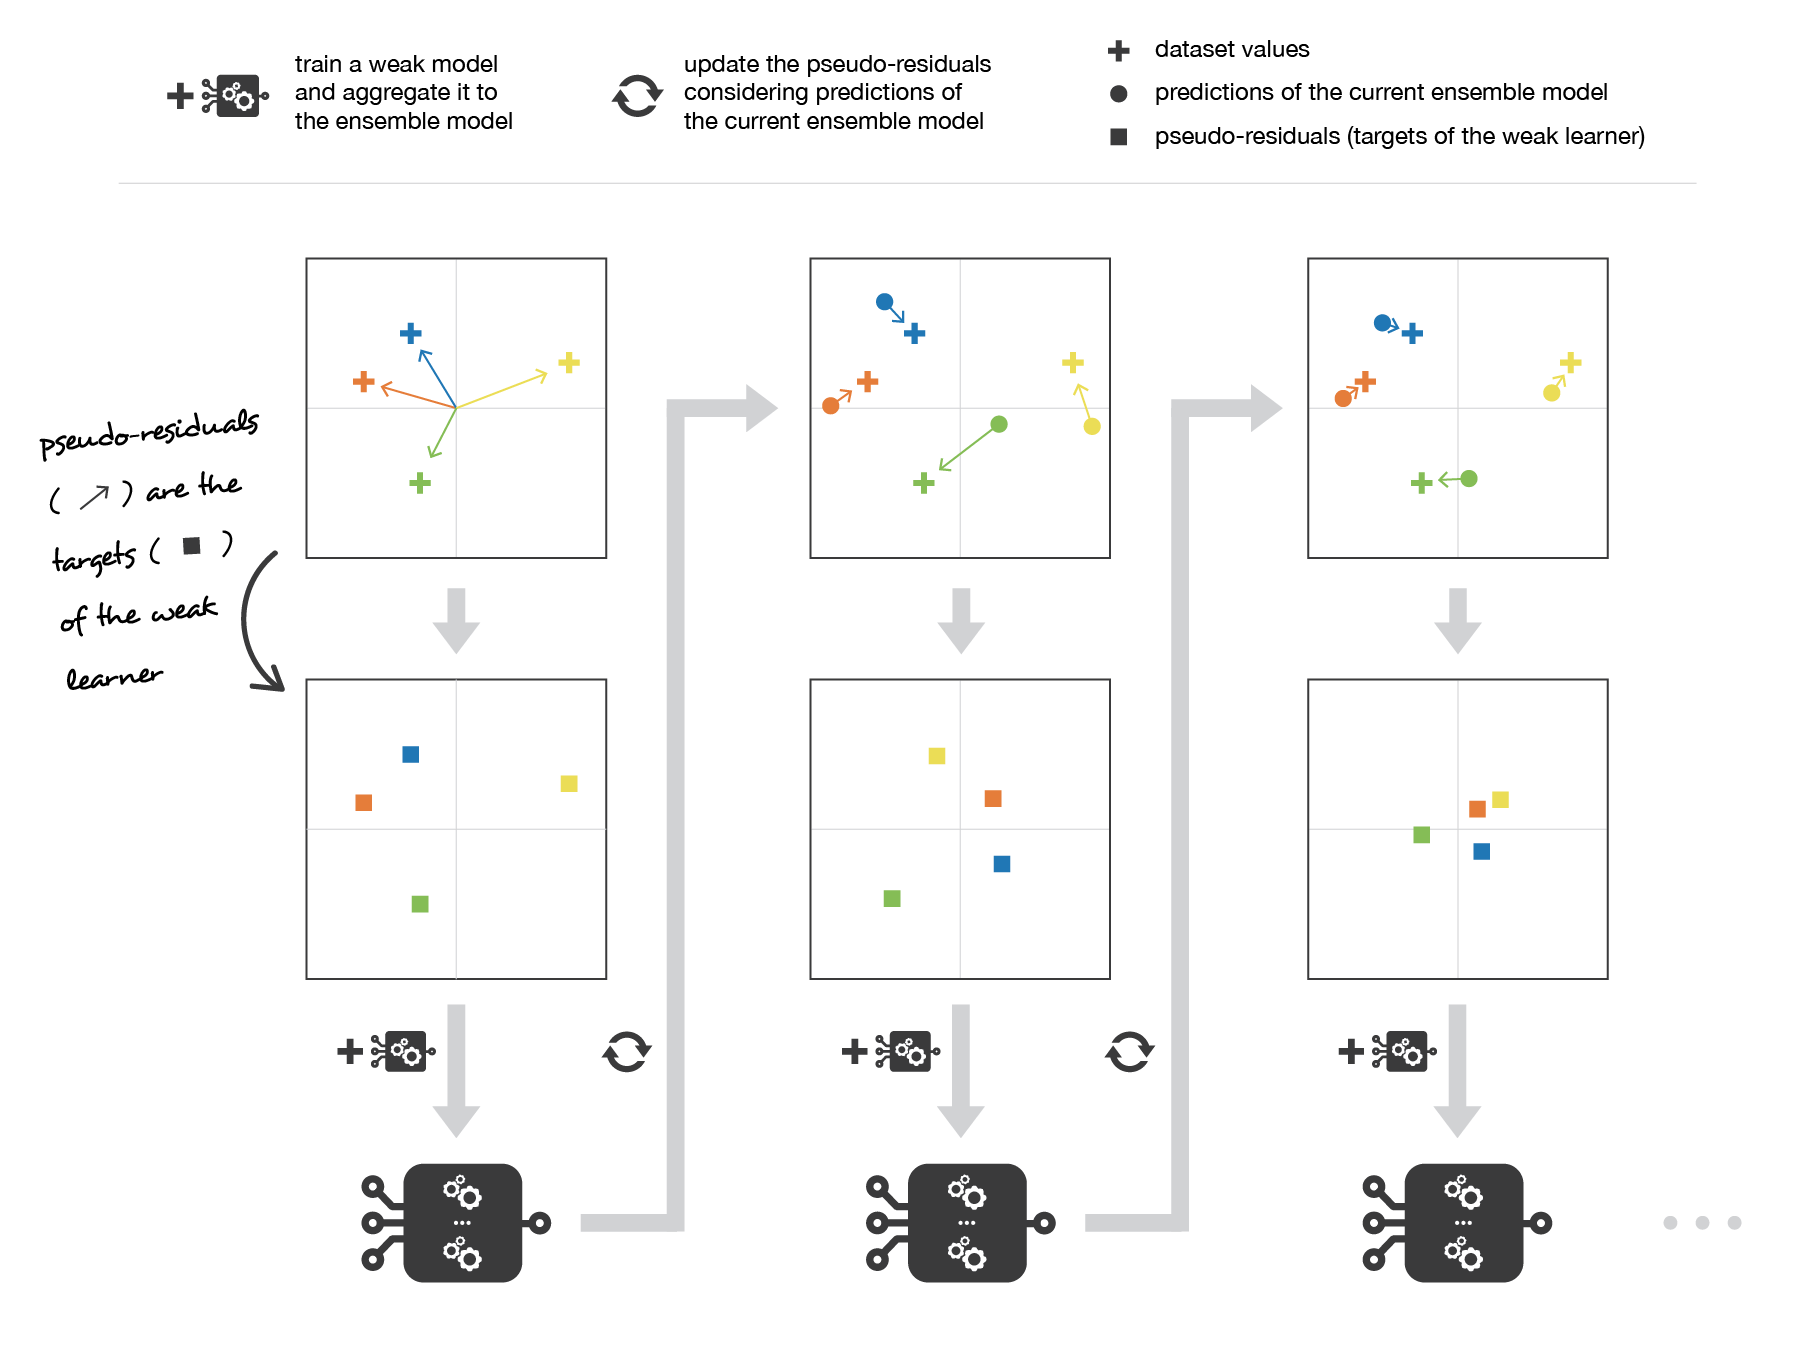

In [2]:
Image('images/gradboost.png')

[Красивые картинки](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)

# Градиентный бустинг. Регрессия

Выполняем в точности алгоритм, который описан выше, предварительно найдя все производные

### Функция потерь

* **ls**(least squares)
$$\mathcal{L(a, x_i, y_i)} = MSE = (a(x_i) - y_i)^2$$
или
* **lad**(least absolute deviation)
$$\mathcal{L(a, x_i, y_i)} = MAE = |a(x_i) - y_i|$$

или даже что-то более сложное

* **Quanltile** loss 
$$
L_{0.75}(a, x_i, y_i) = 
\begin{cases}
0.25 |y_i - a(x_i)|, ~~~ y - f \leq 0 \\
0.75 |y_i - a(x_i)|, ~~~ y - f > 0
\end{cases}
$$

еще есть [Huber loss](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%BF%D0%BE%D1%82%D0%B5%D1%80%D1%8C_%D0%A5%D1%8C%D1%8E%D0%B1%D0%B5%D1%80%D0%B0), а в целом можно использовать любые другие функции, если задача того требует

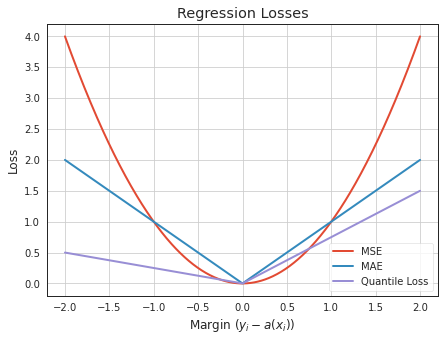

In [3]:
x = np.linspace(-2, 2, 500)

plt.plot(x, x**2, lw=2, label='MSE')
plt.plot(x, np.abs(x), lw=2, label='MAE')
plt.plot(x, np.array([(0.25*np.abs(i) if i < 0 else 0.75*np.abs(i)) for i in x]), 
         lw=2, label='Quantile Loss')
plt.title('Regression Losses')
plt.legend(loc='best')
plt.xlabel('Margin $(y_i - a(x_i))$')
plt.ylabel('Loss')
plt.grid()

# Градиентный бустинг. Бинарная классификация

К постановке задачи классификации есть 2 подхода:
* Оптимизировать функцию правдоподобия (logistic regression)
* Оптимизировать Accuracy (через пороговые функции)

## Правдоподобие

Пусть у нас есть выборка $(X, y)$, где $y \in \{0, 1\}$

Мы помним, что функционал для классификации выводится из максимизации функции правдоподобия

$$Likelihood = \prod_{i=1}^{n}p(f_{t}(x_i)=y_i|x_i) \rightarrow \max$$

Прологорифмировав и поменяв знак, получим

$$-\ln{Likelihood} = Q_t = Q(f_t,X,y) = NegLogLoss = -\sum_{i=1}^{N} y_{i}\ln p(f_t, x_i) + (1 - y_{i})\ln(1 - p(f_t, x_i))$$

$$p(f_t, x_i) = P(f_t(x_i)=1| x_i) = \sigma(f_t(x_i)),~~~~ \textrm{где}~~\sigma(x)=\frac{1}{1-e^{-x}}$$


Итого мы находим нужные производные функции потерь

$$\mathcal{L}(f_t, x_i, y_i) = y_{i}\ln \sigma(f_t, x_i) + (1 - y_{i})\ln(1 - \sigma(f_t, x_i))$$

$$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N$$

А теперь находим $f_{t+1}$ через решение регрессии

Результат же мы также будем получать через вероятность. 

Пусть $f_T(x)$ - итоговый алгоритм, тогда:

$$a(x) = \begin{cases}
1, & \sigma(f_T(x)) > 0.5 \\ 
0, & \sigma(f_T(x)) < 0.5 \\ 
\end{cases}$$

## Accuracy

### Постановка задачи
* $(X, y)_{N}$ - тренировочная выборка длины $N$, где $y_i \in \{-1, 1\}$ ($-1$ вместо $0$ - удобнее для алгоритма)
* $Q(a, X, y)$ - **количество ошибок**


$$Q(a, X, y) = \sum_{i=1}^{N}\mathcal{I}(y_i \neq a(x)) = \sum_{i=1}^{N}[y_ia(x_i) < 0] =\sum_{i=1}^{N}[M < 0]$$

$[M < 0]$ - пороговая функция, которая равная $1$, если условие выполняется и $0$, если не выполняется

Таким образом получим, что если реальный ответ и ответ алгоритма не совпадают - значение $M$ будет отрицательно и пороговая функция обратится в 0, иначе в 1.

Если мы ищем алгоритм в виде бустинга, то получим

$$a(x) = \sum_{t = 1}^T \alpha_t b_t(x)$$

$$Q_T(X, y) = \sum_{i=1}^{N}\Big[y_i\sum_{t = 1}^T \alpha_t b_t(x) < 0\Big]$$


Основная задача теперь - как-то гладко **аппроксимировать** функцию потерь, чтобы можно было взять **производные**. Так как мы хотим уменьшать $Q$, нам нужно заменить его на такую функцию $\tilde{Q}$, которая во всех точках больше пороговой функции.

Используя различные аппроксимации для пороговой функции потерь $[M < 0]$, будем получать различные виды бустинга. Примеры:
- $e^{-M}$ - AdaBoost, экспоненциальная функция потерь
- $\log_2(1 + e^{-M})$ - LogitBoost, логарифмическая функция потерь
- $(1 - M)^2$ - GentleBoost, квадратичная функция потерь
- $e^{-cM(M+a)}$ - BrownBoost, гауссова функция потерь
- другие

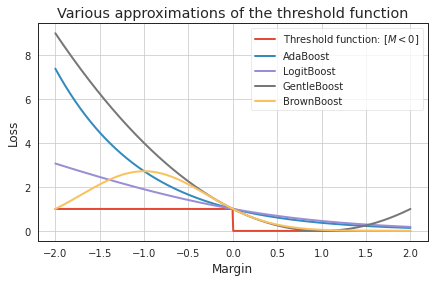

In [4]:
x = np.linspace(-2, 2, 500)

plt.figure(figsize=(7,4))
plt.plot(x, x < 0, lw=2, label='Threshold function: $[M < 0$]')
plt.plot(x, np.exp(-x), lw=2, label='AdaBoost')
plt.plot(x, np.log2(1 + np.exp(-x)), lw=2, label='LogitBoost')
plt.plot(x, (1 - x) ** 2, lw=2, label='GentleBoost')
plt.plot(x, np.exp(-x * (x + 2)), lw=2, label='BrownBoost')
plt.title('Various approximations of the threshold function')
plt.legend(loc='best')
plt.xlabel('Margin')
plt.ylabel('Loss')
plt.grid()

### AdaBoost
Пусть возьмем экспоненциальную функцию потерь (по сути можно любую) и реализуем необходимый алгоритм, найдя производные

$$\mathcal{Q}(f_t, x_i, y_i) = \sum_{i=1}^{N}e^{-y_if_t(x_i)}$$

$$\mathcal{L}(f_t, x_i, y_i) = e^{-y_if_t(x_i)}$$


$$g_{i}^{t} = -\Big[\frac{\partial \mathcal{L}(f_t, x_i, y_i)}{\partial f_t(x_i)}\Big]_{i=1}^N = 
-\Big[-y_ie^{-y_if_t(x_i)}\Big]_{i=1}^N = \Big[y_ie^{-y_if_t(x_i)}\Big]_{i=1}^N$$

А теперь находим $f_{t+1}$ через решение регрессии

На самом деле получили в точности AdaBoost. Мы обучаем реграссию на **взвешенных** аргументах: $y_ie^{-y_if_t(x_i)} = y_iw_i$ 

Полученный итоговый алгоритм возвращает значения из $[0,1]$, а дальше выбираем по порогу, к какому классу отнести ответ при ответе.

# Очень Важные дополнения

1. **Learning rate**. На шаге, когда мы добавляем новый алгоритм к композиции, можно умножать новое слагаемое на коэффициент $\gamma$:
$$f_t(x) = f_{t-1}(x) + \gamma\alpha_t b_t(x)$$

    Данная опция выступает в качестве регуляризации. Рекомендованное значение $\gamma \leq 0.1$

2. **SGD**. Вместо градиентного спуска, очевидно, можно использовать стохастический для ускорения (По дефолту он обычно и используется). Можно использовать и другие методы спусков: Momentum, Adam e.t.c.

3. Почти всегда на практике в качестве базовых деревьев используются **деревья решений**.

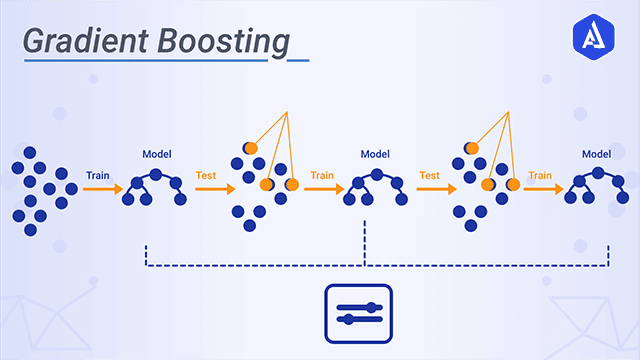

In [5]:
Image('images/boosttree.png')

# Bias-Variance trade-off

В случае комбинации алгоритмов мы уделяем большое внимание тому как у нас изменяется Bias-variance trade-off от числа базовых алгоритмов. 

В RandomForest мы использовали достаточно простую модель и считали деревья независимыми. Основным утверждением было то, что увеличение количества деревьев **уменьшает Variance и не меняет Bias**.

Однако в Бустинге все ровно наоборот.

Данные рассуждения не будут иметь под собой математические доказательства, в силу сложности модели, однако определенные рассуждения мы имеем право делать.

Основной ход бустинга протекает следующим образом:
1. Берем очень простой алгоритм (константа)
2. Ищем объекты, которые дальше всего находятся от алгоритма (большой градиент).
3. С помощью дополнительного алгоритма приближаем данные значения к общему алгоритму.
4. Повторяем операцию

Получается, что мы постепенно **уменьшаем Bias** модели, при этом из-за сильной зависимости модели **variance не увеличивается**. 

**Variance увеличивается** при большом **learning rate**. В этом случае алгоритм очень быстро *приближается* к объектам из-за чего он может начать сильно колебаться.
 


## Посмотрим на примере
Сгенерируем какую-нибудь [страшную функцию](https://ru.wikipedia.org/wiki/%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D0%A0%D0%BE%D0%B7%D0%B5%D0%BD%D0%B1%D1%80%D0%BE%D0%BA%D0%B0)

In [6]:
def generate_rosenbrock(n, variance=0):
    X = np.random.random((n, 2))
    X[:, 0] = (X[:, 0] - 0.5) * 4
    X[:, 1] = ((X[:, 1] - 0.5) * 4) + 1
    y = np.zeros(n)
    for i in range(n):
        y[i] = 100 * np.square(X[i, 1] - (X[i, 0] * X[i, 0])) + np.square(1 - X[i, 0])
    noise = np.random.normal(scale=np.sqrt(variance), size=n)
    y = y + noise
    return X, y, noise

И запустим эксперимент для поиска Bias и Variance. 

Подробный код можно найти в файле `biasvar.py` в целом там чисто техника, логики особо важной нет. Код нагло позаимствован [отсюда](https://github.com/RAMitchell/xgb-bias-variance).

In [8]:
from biasvar import *

def experiment_gbm_rounds():
    n_estimators_range = range(10, 45, 5)
    models = [xgb.XGBRegressor(n_estimators=n_estimators) for n_estimators in n_estimators_range]
    results = []
    for model in models:
        results.append(get_biasvar(base_model=model,generator=generate_rosenbrock))
    
    plot_experiment("Bias Variance Decomposition - Gradient Boosting", "Boosting Rounds",
                    n_estimators_range,
                    results)

CPU times: user 48.4 s, sys: 722 ms, total: 49.1 s
Wall time: 6.34 s


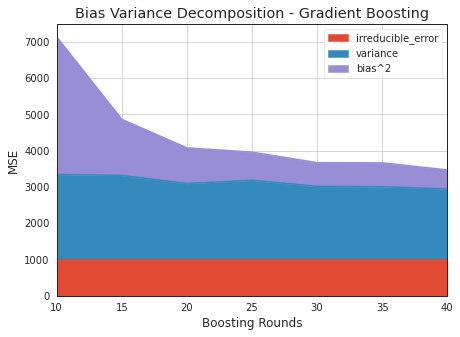

In [9]:
%%time
experiment_gbm_rounds()

In [10]:
def experiment_gbm_learning_rate():
    learning_rate_range = np.linspace(0.1, 1.0)
    models = [xgb.XGBRegressor(learning_rate=learning_rate) for learning_rate in
              learning_rate_range]
    results = []
    for model in models:
        results.append(get_biasvar(base_model=model,generator=generate_rosenbrock))
    
    plot_experiment("Bias Variance Decomposition - Gradient Boosting", "Learning rate",
                    learning_rate_range,
                    results)

CPU times: user 18min 53s, sys: 13.9 s, total: 19min 7s
Wall time: 2min 37s


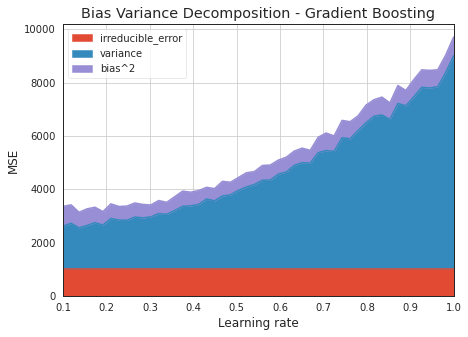

In [11]:
%%time
experiment_gbm_learning_rate()

## Эмпирическое правило

#### В случае **Бустинга** мы уменьшаем Bias, но слабо влияем на Variance, поэтому за базовые алгоритмы нужно брать **короткие деревья**, так как у них большой Bias и малый Variance.

#### В случае **Случайного леса** мы уменьшаем Variance,  и не меняем Bias, поэтому за базовые алгоритмы нужно брать **глубокие деревья**, так как у них большой Variance и малый Bias.


# Практика. Sklearn GradientBoosting

В sklearn можно найти реализацию алгоритмов [GradientBoostingClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) и [GradientBoostingRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html)

Несмотря на общую теорию, на практике в бустинге почти всегда используются **Деревья решений** в качестве базовых алгоритмов. 

# Пример регрессии

In [3]:
n_train, n_test, noise = 150, 1000, 0.1
# Generate data
def f(x):
    x = x.ravel()
    return np.exp(-x ** 2) + 1.5 * np.exp(-(x - 2) ** 2)

def generate(n_samples, noise):
    X = np.random.rand(n_samples) * 10 - 5
    X = np.sort(X).ravel()
    y = np.exp(-X ** 2) + 1.5 * np.exp(-(X - 2) ** 2)\
        + np.random.normal(0.0, noise, n_samples)
    X = X.reshape((n_samples, 1))

    return X, y

X_train, y_train = generate(n_samples=n_train, noise=noise)
X_test, y_test = generate(n_samples=n_test, noise=noise)

In [4]:
def predict_and_plot(model, X_test, y_test, title):
    y_predict = model.predict(X_test)

    plt.plot(X_test, f(X_test), "b")
    plt.scatter(X_train, y_train, c="b", s=20)
    plt.plot(X_test, y_predict, "g", lw=2)
    plt.xlim([-5, 5])
    plt.title("{} Loss: {:2f}".format(title, model.score(X_test, y_test)))
    plt.grid()

### Сравним простое дерево и бустинг на деревьях высоты 3

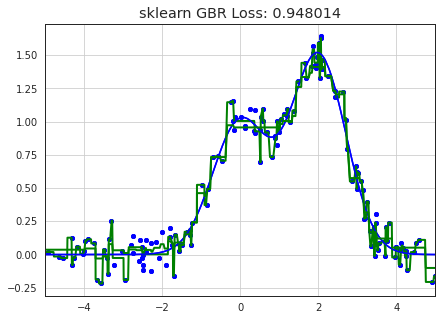

In [20]:
dtree = DTR(max_depth=10).fit(X_train, y_train)
predict_and_plot(dtree, X_test, y_test, "DTR")

# GradientBoostingRegressor
gbr = GradientBoostingRegressor(n_estimators=30, #зададим количество деревеьев
         loss='ls', # MSE
         max_depth=3, #невысокие деревья, НО НЕ ПЕНЬКИ
         random_state=128).fit(X_train, y_train)


predict_and_plot(gbr, X_test, y_test, "sklearn GBR")
plt.grid()

## Как меняется предсказание в зависимости от количества деревьев

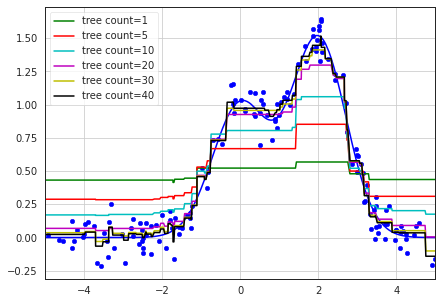

In [22]:
# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
n_est = [1, 5, 10, 20, 30, 40]
for i, n in enumerate(n_est):
    gbr = GradientBoostingRegressor(n_estimators=n, #зададим количество деревеьев
              loss='ls', # MSE
              max_depth=3 #невысокие деревья
             ).fit(X_train, y_train)
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    y_predict = gbr.predict(X_test)
    plt.plot(X_test, y_predict, color=colors[i], label="tree count={}".format(n))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()

Наше дерево по чуть-чуть собирается и добирает нужную сложность предсказываемой функции.

### Зависимость от метрик

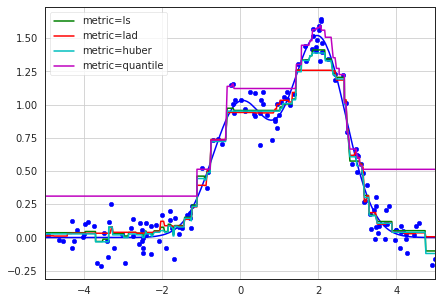

In [25]:
# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
metric = ["ls", 'lad', "huber", "quantile"]
for i, m in enumerate(metric):
    gbr = GradientBoostingRegressor(n_estimators=30, #зададим количество деревеьев
         loss=m, 
         max_depth=3 #невысокие деревья
         ).fit(X_train, y_train)
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    y_predict = gbr.predict(X_test)
    plt.plot(X_test, y_predict, color=colors[i], label="metric={}".format(m))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()

## Зависимость от высоты базовых деревьев

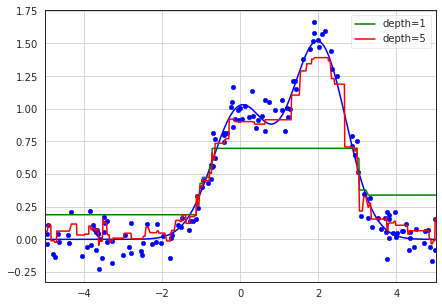

In [8]:
# GradientBoostingRegressor
plt.plot(X_test, f(X_test), "b")
plt.scatter(X_train, y_train, c="b", s=20)
n_depth = [1, 5]
for i, n in enumerate(n_depth):
    gbr = GradientBoostingRegressor(n_estimators=20, #зададим количество деревеьев
         loss='ls', # MSE
         max_depth=n #невысокие деревья
         ).fit(X_train, y_train)
    colors = ['g', 'r', 'c', 'm', 'y', 'k']
    y_predict = gbr.predict(X_test)
    plt.plot(X_test, y_predict, color=colors[i], label="depth={}".format(n))

plt.xlim([-5, 5])   
plt.legend()
plt.grid()
plt.show()

# Примеры классификация

In [27]:
from random import gauss
num_samples = 100
theta = np.linspace(0, 2*np.pi, num_samples)

r1 = 1
r2 = 1.5

rng = np.random.RandomState(1)

circle = np.hstack([np.cos(theta).reshape((-1, 1)) + (rng.randn(num_samples)[:,np.newaxis] / 8), 
                    np.sin(theta).reshape((-1, 1)) + (rng.randn(num_samples)[:,np.newaxis] / 8)])
lil = r1 * circle
big = r2 * circle
X = np.vstack([lil, big])
y = np.hstack([np.zeros(num_samples), np.ones(num_samples)])



## Зависимость от функций потерь

GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
                           learning_rate=0.1, loss='exponential', max_depth=3,
                           max_features=None, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.0, n_estimators=30,
                           n_iter_no_change=None, presort='deprecated',
                           random_state=42, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

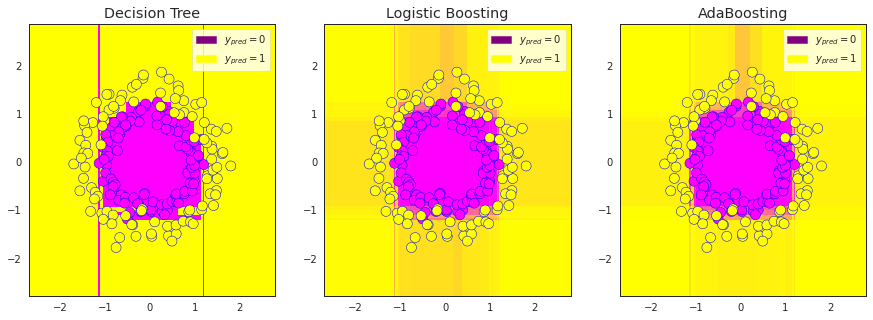

In [30]:
fig = plt.figure(figsize = (15,5))

fig.add_subplot(1,3,1)
dtree = DTR(max_depth=10,
            random_state=42).fit(X, y)
    
plot_model(X, y, dtree, title="Decision Tree", proba=False)

fig.add_subplot(1,3,2)
gbc = GradientBoostingClassifier(loss='deviance', # logistic regression
          n_estimators=30,
          max_depth= 3,
          random_state=42).fit(X, y)
    
plot_model(X, y, gbc, title="Logistic Boosting", proba=True)

fig.add_subplot(1,3,3)
gbc = GradientBoostingClassifier(loss='exponential', # adaboost
          n_estimators=30,
          max_depth= 3,
          random_state=42).fit(X, y)
    
plot_model(X, y, gbc, title="AdaBoosting", proba=True)

## Зависимость от количества деревьев

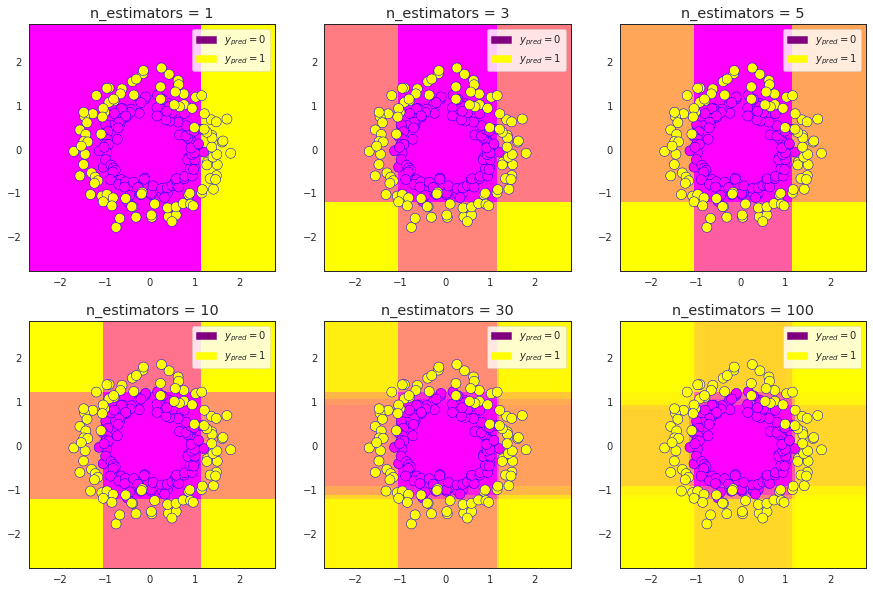

In [31]:
fig = plt.figure(figsize = (15,10))
n_est = [1,3,5,10,30,100]
for m in range(0, 6):
    fig.add_subplot(2,3,m+1)
    gbc = GradientBoostingClassifier(n_estimators=n_est[m],
              max_depth=1,
              random_state=42).fit(X, y) # обучаем модель
    plot_model(X,y,gbc,
               title='n_estimators = {}'.format(n_est[m]),
               proba=True)

## Зависимость от глубины дерева

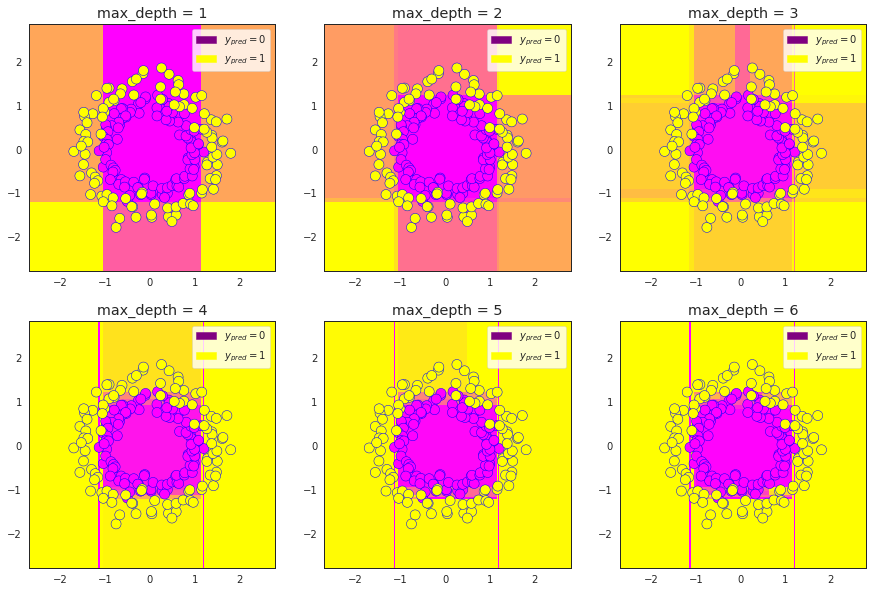

In [20]:
fig = plt.figure(figsize = (15,10))
for m in range(0, 6):
    fig.add_subplot(2,3,m+1)
    gbc = GradientBoostingClassifier(n_estimators=5,
              max_depth=m+1,
              random_state=42).fit(X, y) # обучаем модель
    plot_model(X,y,gbc,
               title='max_depth = {}'.format(m+1),
               proba=True)

# Итог
Основное отличие Random Forest от Boosting в том, что в первом случае мы используем комбинацию **независимых** между собой деревьев, а во втором - последовательно **зависимых** алгоритмов. 

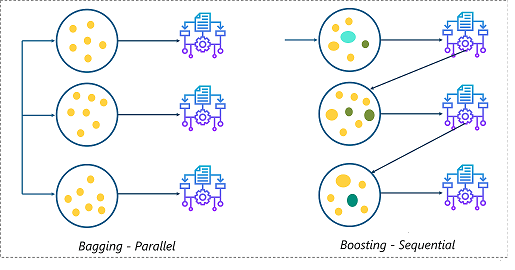

In [15]:
Image('diff.png')

В градиентом бустинге мы берем начальное приближение базовым алгоритмом, а дальше начинаем добавлять градиенты функции потерь к нашему ответу. 

# Источники и полезные материалы

* [Бустинг. Хабр. ODS](https://habr.com/ru/company/ods/blog/327250/) - очень крутая статья
* [Kaggle Notebook](https://www.kaggle.com/grroverpr/gradient-boosting-simplified/) - дерево решений и бустинг регрессиии своими руками
## Полезные ссылки
- <a href="https://en.wikipedia.org/wiki/Boosting_(machine_learning)">Boosting</a>
- [Gradient boosting](https://en.wikipedia.org/wiki/Gradient_boosting)
- [Лекция](http://www.machinelearning.ru/wiki/images/c/cd/Voron-ML-Compositions-slides.pdf) К.В. Воронцова по композиционным методам классификации
- <a href="https://github.com/dmlc/xgboost">Xgboost</a>
- <a href="https://github.com/ChenglongChen/Kaggle_CrowdFlower">Обзор</a> решения победителя соревнования Kaggle "CrowdFlower" по предсказанию релевантности выдачи поисковика товаров. Решение на основе Xgboost
* [Bias-variance NVIDIA](https://devblogs.nvidia.com/bias-variance-decompositions-using-xgboost/)
* [Bagging, Boosting, Stacking](https://towardsdatascience.com/ensemble-methods-bagging-boosting-and-stacking-c9214a10a205)
* [Boosted trees. Xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [Bias-variance. NVIDIA Code](https://github.com/RAMitchell/xgb-bias-variance/blob/master/xgb-bias-variance.py)
* [Introduction to Boosted trees](https://homes.cs.washington.edu/~tqchen/pdf/BoostedTree.pdf)
* [Boosting lecture](https://drive.google.com/file/d/1PSK7IPNGEhlI6x0GgTtDp9woNejexhYW/view)
* [Визуализация](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)